In [168]:
import fixed_income_derivatives_E2024 as fid
from numpy.linalg import solve, inv
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, root_scalar, minimize_scalar
from scipy.stats import norm, ncx2, gamma
import copy
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
import seaborn as sns

# Problem 2


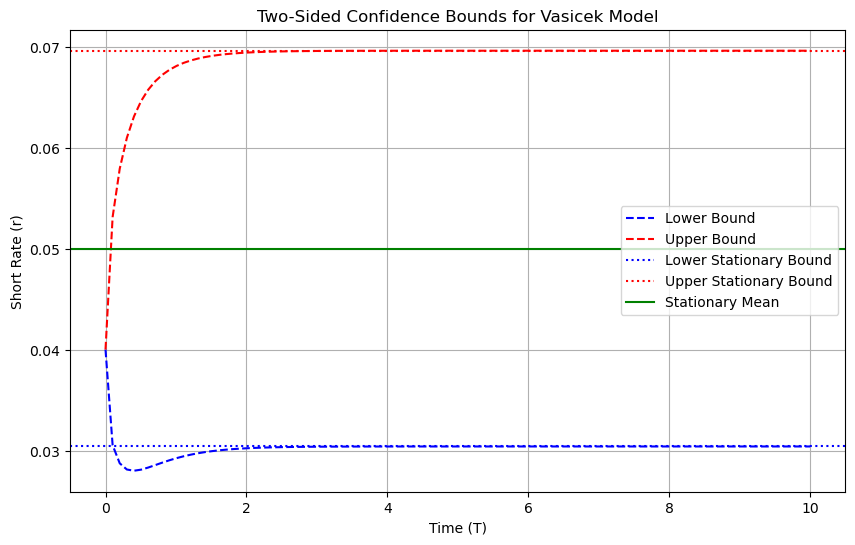

In [156]:
# 2a+b)
T = np.linspace(0, 10, 100)
r0 = 0.04
a = 2
b = 0.1
sigma = 0.02
alpha = 0.95
confidence_level = alpha

def vasicek_confidence_bounds(T, r0, a, b, sigma, alpha=0.95):
    """
    Calculate the two-sided confidence bounds for the Vasicek model.
    
    Parameters:
        T: Time horizon (can be an array or scalar)
        r0: Initial short rate
        a: Speed of mean reversion
        b: Long-term mean
        sigma: Volatility
        alpha: Confidence level (default 0.95)
    
    Returns:
        lower_bound, upper_bound, mean_rt: Arrays of the confidence bounds and the mean 
    """
    mean_rt = np.exp(-a * T) * r0 + (b / a) * (1 - np.exp(-a * T))
    variance_rt = (sigma ** 2) / (2 * a) * (1 - np.exp(-2 * a * T))
    std_rt = np.sqrt(variance_rt)
    z = norm.ppf(1 - (1 - alpha) / 2)
    lower_bound = mean_rt - z * std_rt
    upper_bound = mean_rt + z * std_rt
    return lower_bound, upper_bound, mean_rt

T = np.linspace(0, 10, 100)

# Compute bounds over time
lower_bound, upper_bound, mean_rt = vasicek_confidence_bounds(T, r0, a, b, sigma, alpha)

# Calculate stationary distribution bounds
mean_stationary = b / a
variance_stationary = (sigma ** 2) / (2 * a)
std_stationary = np.sqrt(variance_stationary)
z = norm.ppf(1 - (1 - confidence_level) / 2)
lower_stationary = mean_stationary - z * std_stationary
upper_stationary = mean_stationary + z * std_stationary

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(T, lower_bound, label="Lower Bound", linestyle="--", color="blue")
plt.plot(T, upper_bound, label="Upper Bound", linestyle="--", color="red")
plt.axhline(lower_stationary, color="blue", linestyle=":", label="Lower Stationary Bound")
plt.axhline(upper_stationary, color="red", linestyle=":", label="Upper Stationary Bound")
plt.axhline(mean_stationary, color="green", linestyle="-", label="Stationary Mean")
plt.title("Two-Sided Confidence Bounds for Vasicek Model")
plt.xlabel("Time (T)")
plt.ylabel("Short Rate (r)")
plt.legend()
plt.grid()
plt.show()

In [157]:
# 2c)
a_values = [1, 2, 4, 8]
sigma_values = [0.01, 0.02, 0.03, 0.04]
b_ratio = 0.05  # b / a = 0.05
# Generate time points

T = np.linspace(0, 100, 1000)
# Matrix to store settling times
settling_times = []

# Loop through a and sigma values
for a in a_values:
    row = []
    for sigma in sigma_values:
        # Adjust b to maintain b / a = 0.05
        b = b_ratio * a

        # Calculate bounds over time
        lower_bound, upper_bound, mean_rt = vasicek_confidence_bounds(T, r0, a, b, sigma, alpha=0.95)

        # Calculate stationary bounds
        mean_stationary = b / a
        variance_stationary = (sigma ** 2) / (2 * a)
        std_stationary = np.sqrt(variance_stationary)
        z = norm.ppf(1 - (1 - 0.95) / 2)
        lower_stationary = mean_stationary - z * std_stationary
        upper_stationary = mean_stationary + z * std_stationary

        # Find the time it takes for bounds to settle near the stationary bounds
        threshold = 0.0001  # Convergence threshold
        settled_index = np.where(
            (np.abs(lower_bound - lower_stationary) < threshold) &
            (np.abs(upper_bound - upper_stationary) < threshold)
        )[0]
        settled_time = T[settled_index[0]] if len(settled_index) > 0 else None
        row.append(settled_time)
    settling_times.append(row)

# Convert to DataFrame for better visualization
settling_times_df = pd.DataFrame(settling_times, columns=sigma_values, index=a_values)
settling_times_df.index.name = "a"
settling_times_df.columns.name = "sigma"

# Display the matrix
print("Settling Times Matrix:")
print(settling_times_df)

Settling Times Matrix:
sigma      0.01      0.02      0.03      0.04
a                                            
1      4.704705  4.704705  4.704705  4.704705
2      2.402402  2.402402  2.402402  2.402402
4      1.201201  1.201201  1.201201  1.201201
8      0.600601  0.600601  0.600601  0.600601


Here we see, that the smaller $a$ is, the slower the convergence to the stationary distribution. Moreover, it seems like changing sigma has little to no effect on the size of the confidence bands. 


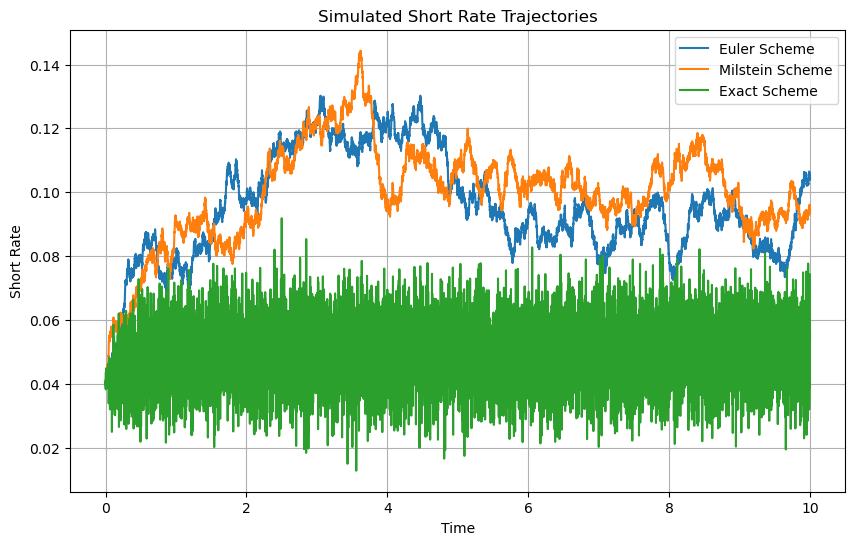

In [158]:
# 2e)
import matplotlib.pyplot as plt

def simulate_vasicek(T, M, r0, a, b, sigma, scheme):
    dt = T / M
    r = np.zeros(M + 1)
    r[0] = r0
    Z = np.random.normal(size=M)  # Standard normal increments
    for m in range(M):
        if scheme == "euler":
            r[m + 1] = r[m] + a * (b - r[m]) * dt + sigma * np.sqrt(dt) * Z[m]
        elif scheme == "milstein":
            dW = np.sqrt(dt) * Z[m]
            r[m + 1] = r[m] + a * (b - r[m]) * dt + sigma * dW + 0.5 * sigma**2 * (-a) * dW**2
        elif scheme == "exact":
            t = (m + 1) * dt
            mean = r0 * np.exp(-a * t) + (b / a) * (1 - np.exp(-a * t))
            variance = (sigma**2) / (2 * a) * (1 - np.exp(-2 * a * t))
            r[m + 1] = np.random.normal(mean, np.sqrt(variance))
    return r

# Simulation parameters
T, M, r0, a, b, sigma = 10, 10000, 0.04, 2, 0.1, 0.02

# Simulate and plot
schemes_to_plot = ["euler", "milstein", "exact"]
plt.figure(figsize=(10, 6))
for scheme in schemes_to_plot:
    r_simul = simulate_vasicek(T, M, r0, a, b, sigma, scheme)
    plt.plot(np.linspace(0, T, M + 1), r_simul, label=f"{scheme.capitalize()} Scheme")
plt.xlabel("Time")
plt.ylabel("Short Rate")
plt.title("Simulated Short Rate Trajectories")
plt.legend()
plt.grid()
plt.show()


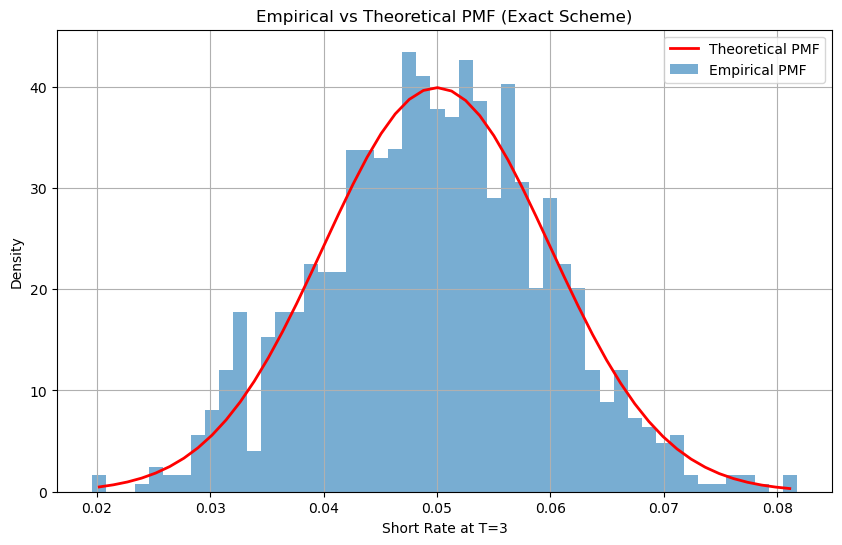

In [159]:
# 2f) 
def empirical_pmf(T, M, N, r0, a, b, sigma, scheme, bins=50):
    r_T = []
    for _ in range(N):
        r = simulate_vasicek(T, M, r0, a, b, sigma, scheme)
        r_T.append(r[-1])
    hist, bin_edges = np.histogram(r_T, bins=bins, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return bin_centers, hist

# Parameters
T, M, N = 3, 1000, 1000
bins = 50
scheme = "exact"

# Empirical PMF
bin_centers, pmf = empirical_pmf(T, M, N, r0, a, b, sigma, scheme, bins)

# Theoretical PMF (Gaussian)
mean = r0 * np.exp(-a * T) + (b / a) * (1 - np.exp(-a * T))
variance = (sigma**2) / (2 * a) * (1 - np.exp(-2 * a * T))
theoretical_pmf = norm.pdf(bin_centers, mean, np.sqrt(variance))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(bin_centers, pmf, width=(bin_centers[1] - bin_centers[0]), alpha=0.6, label="Empirical PMF")
plt.plot(bin_centers, theoretical_pmf, label="Theoretical PMF", color="red", lw=2)
plt.xlabel("Short Rate at T=3")
plt.ylabel("Density")
plt.title(f"Empirical vs Theoretical PMF ({scheme.capitalize()} Scheme)")
plt.legend()
plt.grid()
plt.show()


In [160]:
# 2g)
def total_square_difference(M_vals, N_vals, T, bins, r0, a, b, sigma, scheme):
    results = []
    for M in M_vals:
        for N in N_vals:
            bin_centers, pmf = empirical_pmf(T, M, N, r0, a, b, sigma, scheme, bins)
            mean = r0 * np.exp(-a * T) + (b / a) * (1 - np.exp(-a * T))
            variance = (sigma**2) / (2 * a) * (1 - np.exp(-2 * a * T))
            theoretical_pmf = norm.pdf(bin_centers, mean, np.sqrt(variance))
            squared_diff = np.sum((pmf - theoretical_pmf) ** 2)
            results.append((M, N, squared_diff))
    return results

# Parameters
M_vals = [10000]
N_vals = [10000]
T = 3
bins = 100
scheme = "exact"

# Compute total square differences
results = total_square_difference(M_vals, N_vals, T, bins, r0, a, b, sigma, scheme)

# Display results
for M, N, diff in results:
    print(f"M={M}, N={N}, Total Square Difference={diff:.5f}")

M=10000, N=10000, Total Square Difference=203.78822


# Problem 3

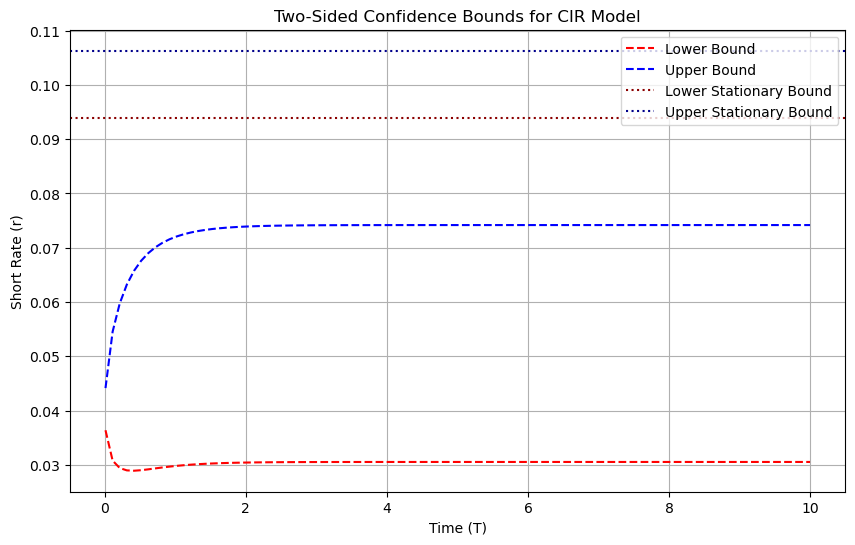

In [161]:
def cir_confidence_bounds(T, r0, a, b, sigma, alpha):
    """
    Compute the lower, upper, and mean bounds for r_T in the CIR model.
    
    Parameters:
        T (float or np.ndarray): Time to maturity (can be scalar or array).
        r0 (float): Initial short rate.
        a (float): Speed of mean reversion.
        b (float): Long-term mean level.
        sigma (float): Volatility parameter.
        alpha (float): Confidence level (default 0.95).
        
    Returns:
        dict: A dictionary containing:
            - lower_bound_rt: Lower confidence bound of r_T.
            - upper_bound_rt: Upper confidence bound of r_T.
    """
    # Degrees of freedom and non-centrality parameter
    k = 4 * a * b / sigma**2
    lambda_t = (4 * a * np.exp(-a * T) * r0) / (sigma**2 * (1 - np.exp(-a * T)))
   
    # Scale factor for the non-central chi-squared distribution
    scale = (sigma**2 / (4 * a)) * (1 - np.exp(-a * T))
    
    # Mean of r_T
    mean_rt = np.exp(-a * T) * r0 + b * (1 - np.exp(-a * T))
    
    # Confidence bounds for r_T using the non-central chi-squared distribution
    lower_quantile = ncx2.ppf((1 - alpha) / 2, k, lambda_t)
    upper_quantile = ncx2.ppf(1 - (1 - alpha) / 2, k, lambda_t)
    lower_bound_rt = lower_quantile * scale
    upper_bound_rt = upper_quantile * scale
    
    return {
        "lower_bound_rt": lower_bound_rt,
        "upper_bound_rt": upper_bound_rt,
    }

# Stationary distribution (Gamma)
alpha_stationary = 2 * a * b / sigma**2
beta_stationary = sigma**2 / (2 * a)
mean_stationary = b / a
lower_stationary = gamma.ppf((1 - alpha) / 2, alpha_stationary, scale=beta_stationary)
upper_stationary = gamma.ppf(1 - (1 - alpha) / 2, alpha_stationary, scale=beta_stationary)
    

# Parameters
T = np.linspace(0.01, 10, 100)  # Time horizon
r0 = 0.04  # Initial rate
a = 2      # Speed of mean reversion
b = 0.05   # Long-term mean
sigma = 0.1  # Volatility
alpha = 0.95  # Confidence level

# Compute CIR bounds
bounds = cir_confidence_bounds(T, r0, a, b, sigma, alpha)
lower_bound = bounds["lower_bound_rt"]
upper_bound = bounds["upper_bound_rt"]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(T, lower_bound, label="Lower Bound", linestyle="--", color="red")
plt.plot(T, upper_bound, label="Upper Bound", linestyle="--", color="blue")
plt.axhline(lower_stationary, color="darkred", linestyle=":", label="Lower Stationary Bound")
plt.axhline(upper_stationary, color="darkblue", linestyle=":", label="Upper Stationary Bound")
plt.title("Two-Sided Confidence Bounds for CIR Model")
plt.xlabel("Time (T)")
plt.ylabel("Short Rate (r)")
plt.legend()
plt.grid()
plt.show()


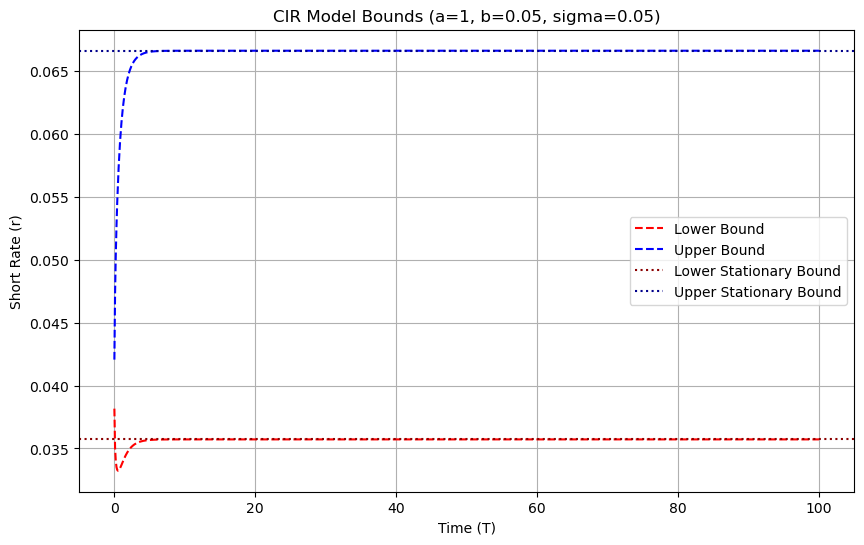

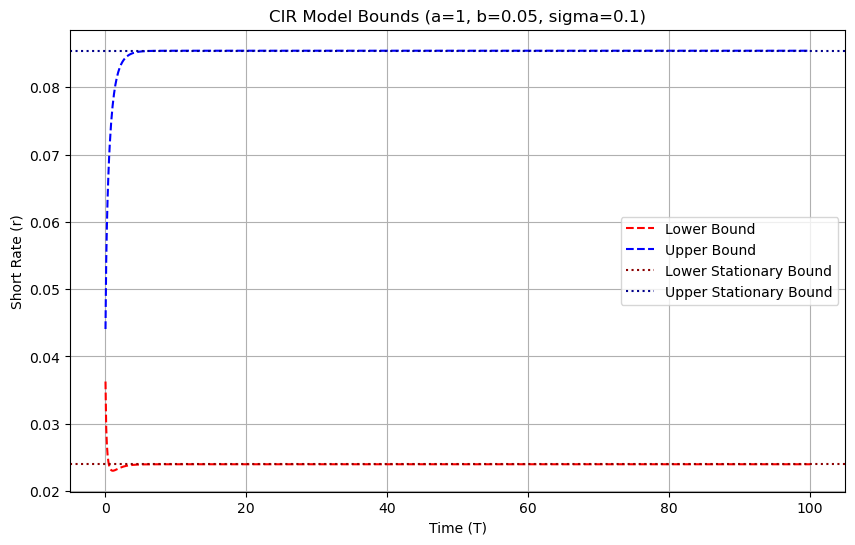

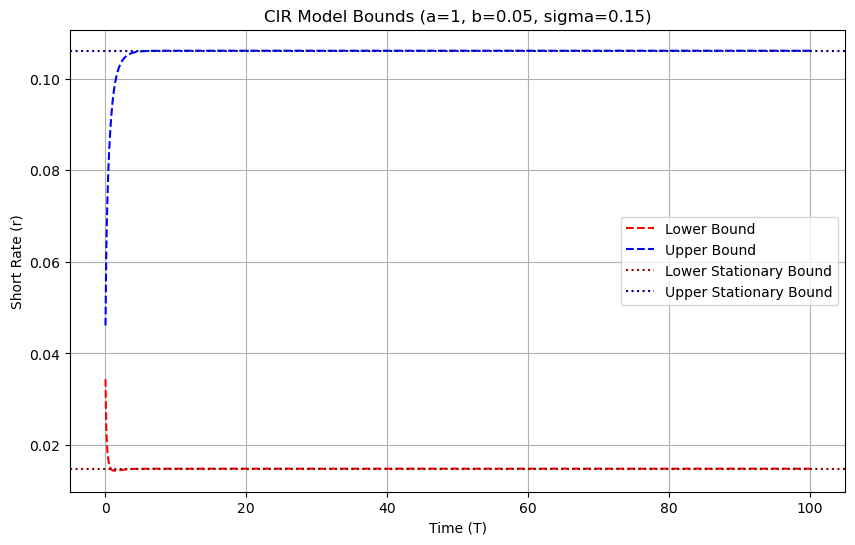

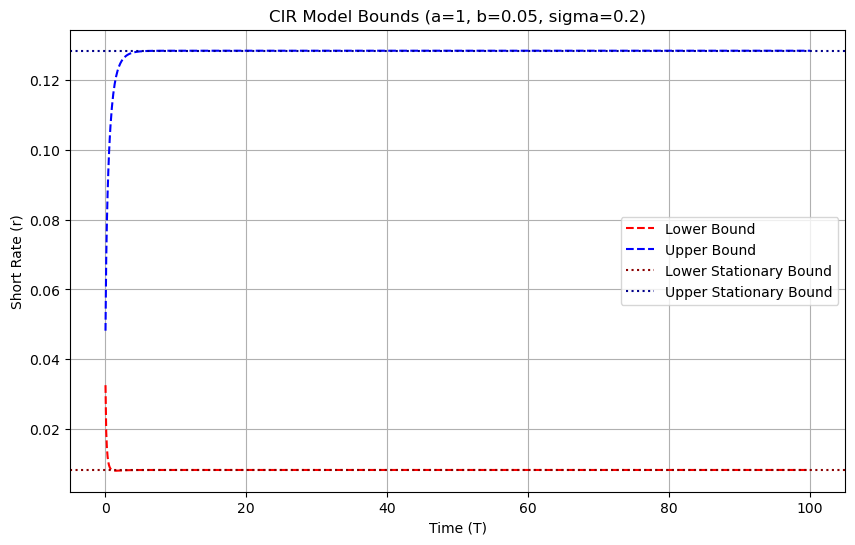

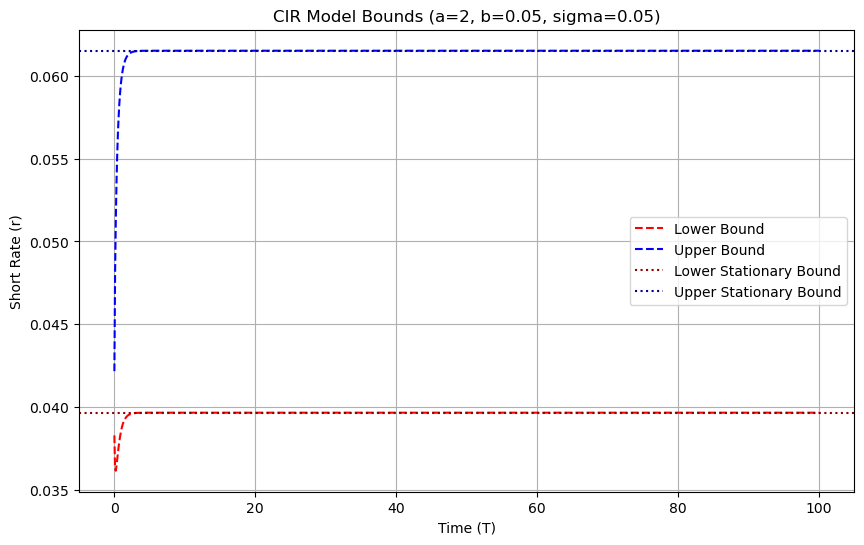

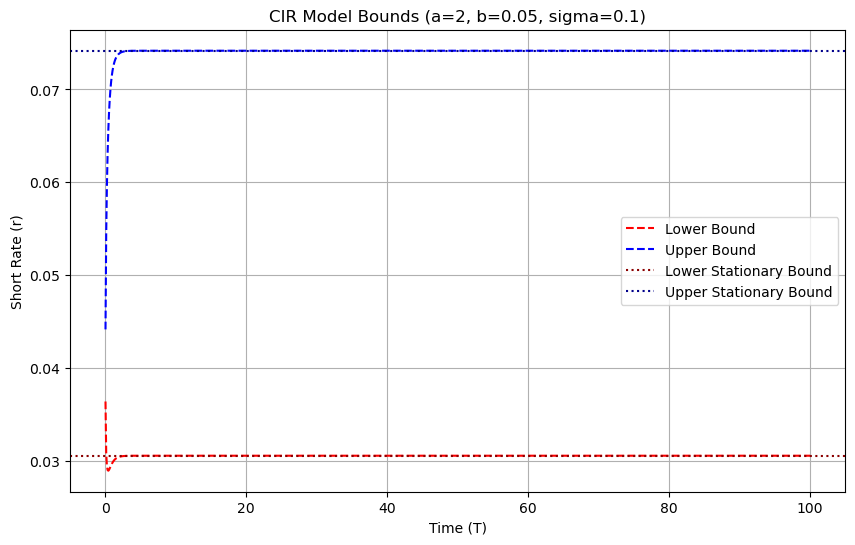

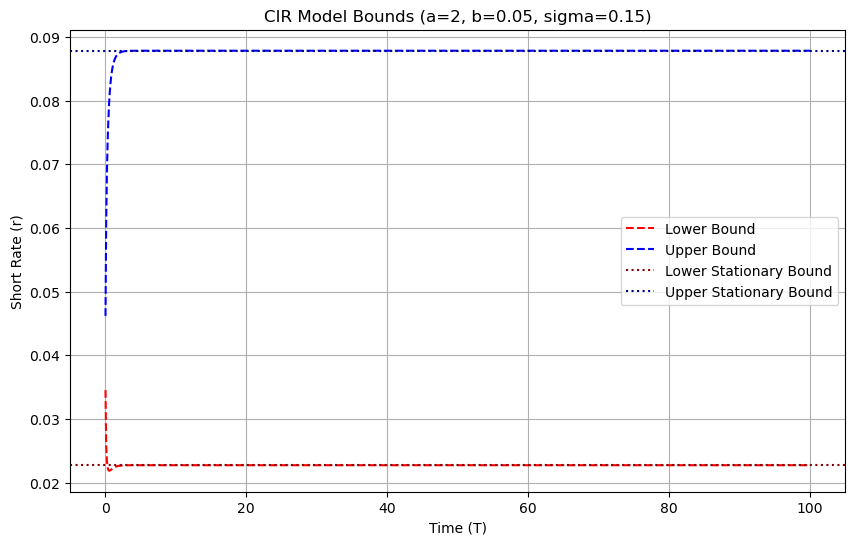

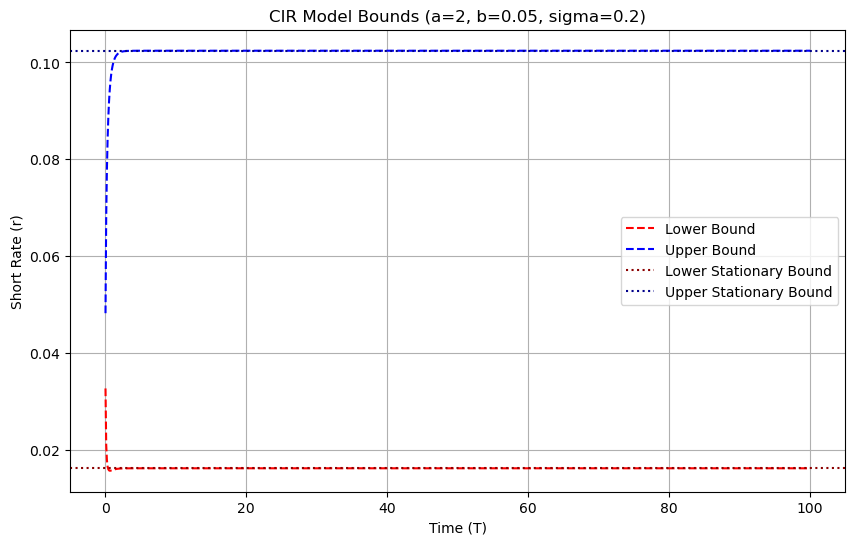

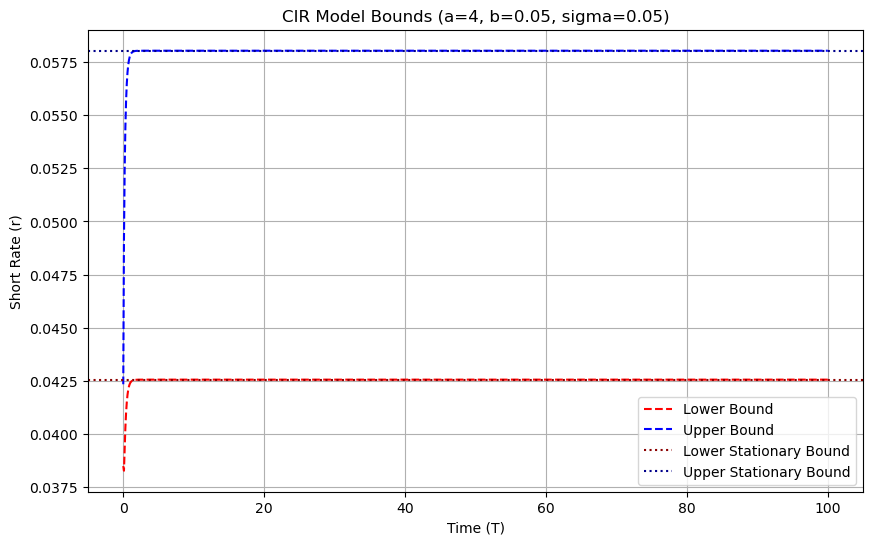

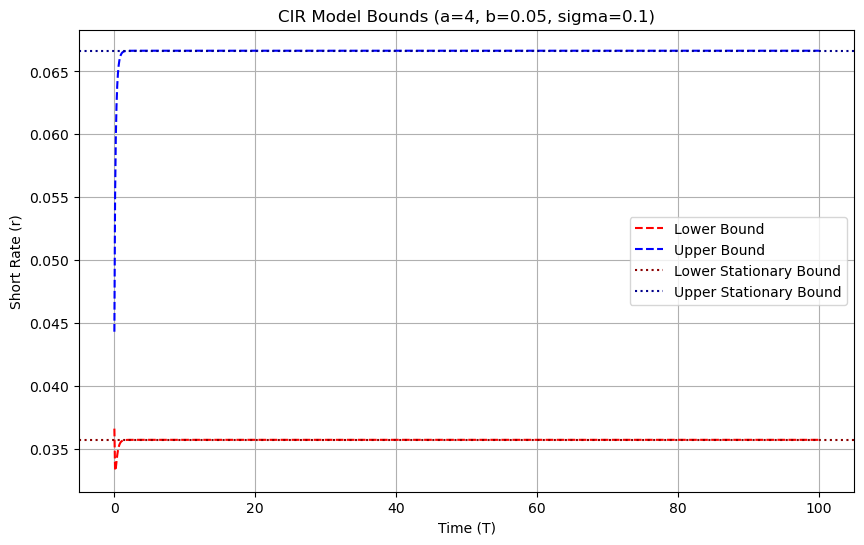

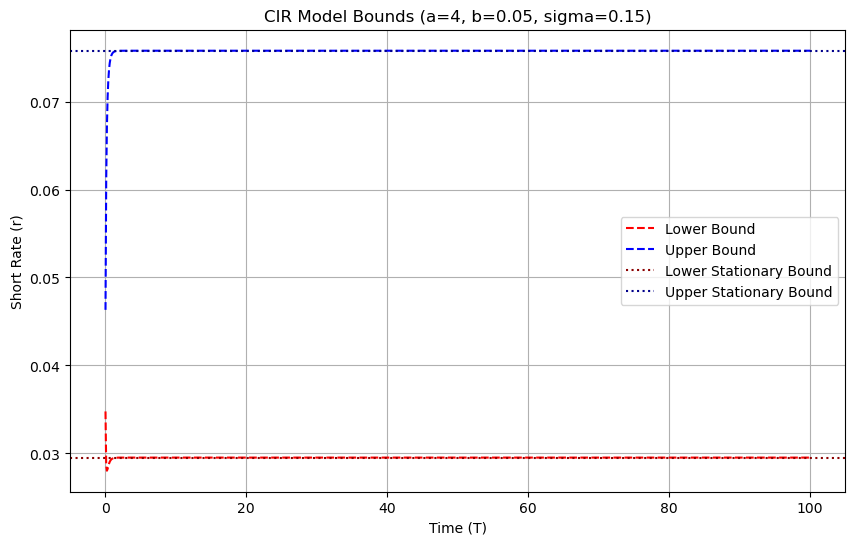

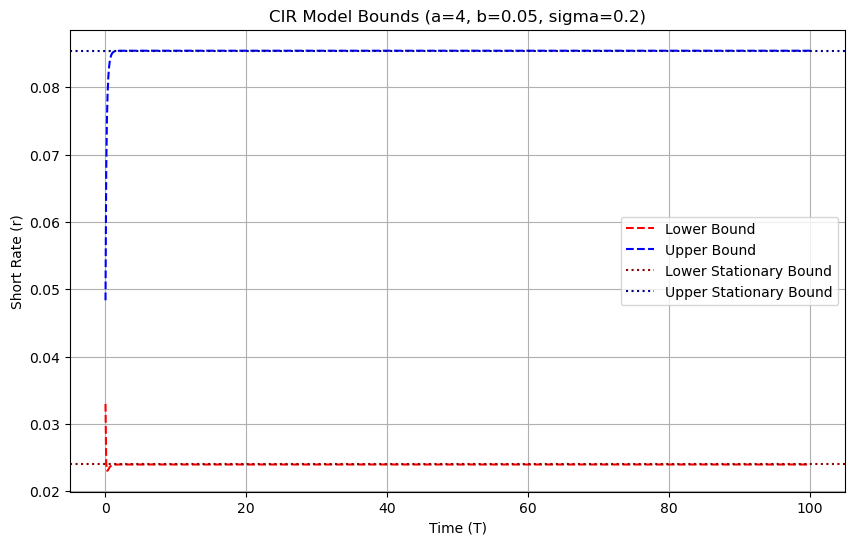

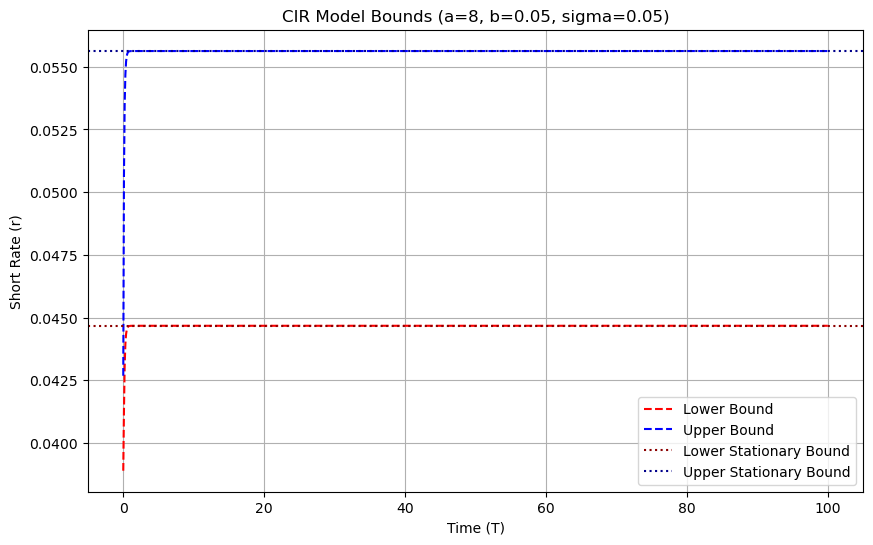

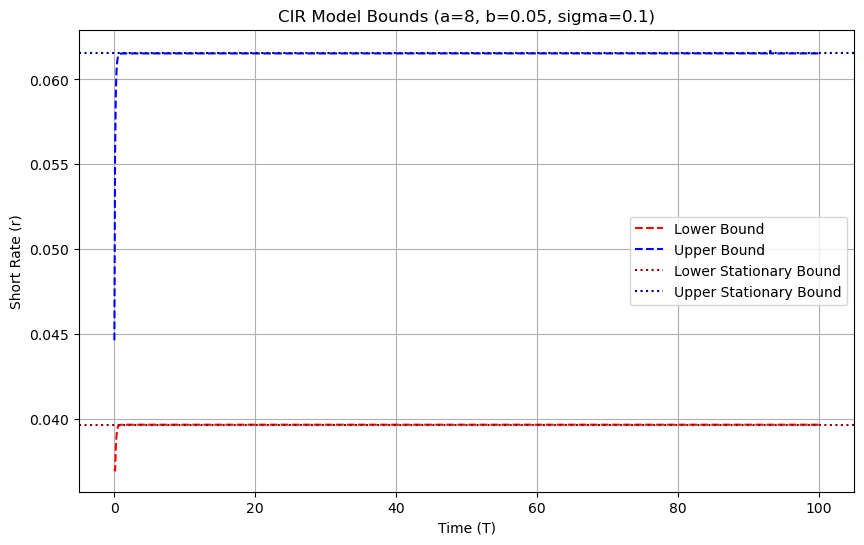

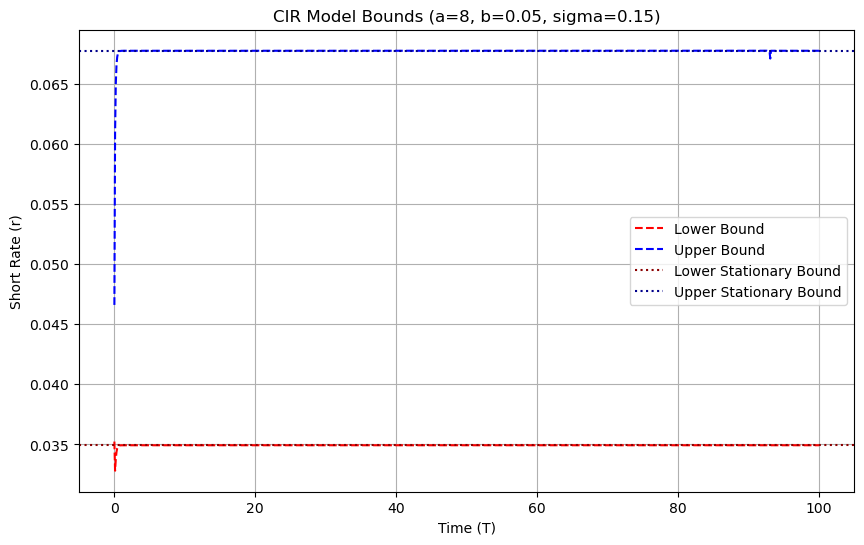

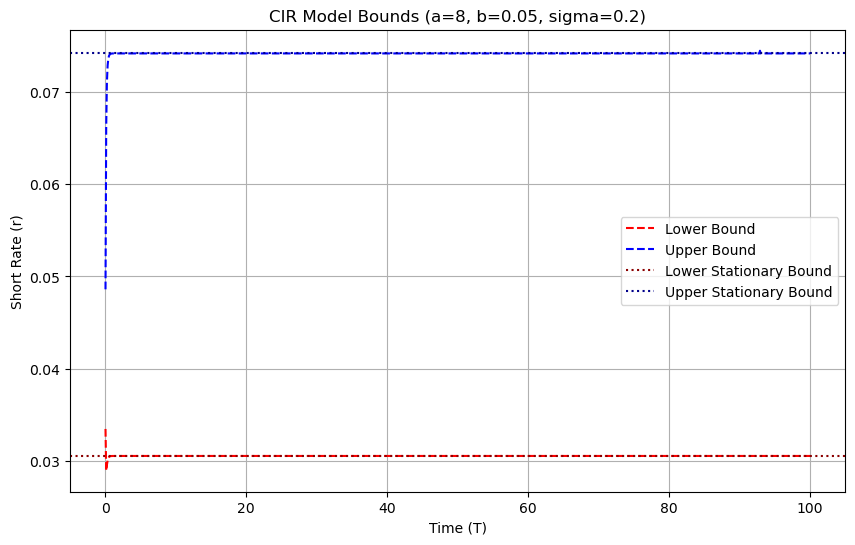

In [162]:
# 3c)
# Parameters
a_values = [1, 2, 4, 8]
sigma_values = [0.05, 0.1, 0.15, 0.2]
b_ratio = 0.05  # b / a = 0.05 - Gotta keep the ratio at 0.05
T = np.linspace(0.01, 100, 1000)  # Time horizon
# Loop over parameter combinations
for a in a_values:
    for sigma in sigma_values:
        # Compute stationary distribution bounds
        alpha_stationary = 2 * a * b / sigma**2
        beta_stationary = sigma**2 / (2 * a)
        lower_stationary = gamma.ppf((1 - alpha) / 2, alpha_stationary, scale=beta_stationary)
        upper_stationary = gamma.ppf(1 - (1 - alpha) / 2, alpha_stationary, scale=beta_stationary)

        # Compute CIR confidence bounds
        bounds = cir_confidence_bounds(T, r0, a, b, sigma, alpha)
        lower_bound = bounds["lower_bound_rt"]
        upper_bound = bounds["upper_bound_rt"]

        # Plot results
        plt.figure(figsize=(10, 6))
        plt.plot(T, lower_bound, label="Lower Bound", linestyle="--", color="red")
        plt.plot(T, upper_bound, label="Upper Bound", linestyle="--", color="blue")
        plt.axhline(lower_stationary, color="darkred", linestyle=":", label="Lower Stationary Bound")
        plt.axhline(upper_stationary, color="darkblue", linestyle=":", label="Upper Stationary Bound")
        plt.title(f"CIR Model Bounds (a={a}, b={b}, sigma={sigma})")
        plt.xlabel("Time (T)")
        plt.ylabel("Short Rate (r)")
        plt.legend()
        plt.grid()
        plt.show()

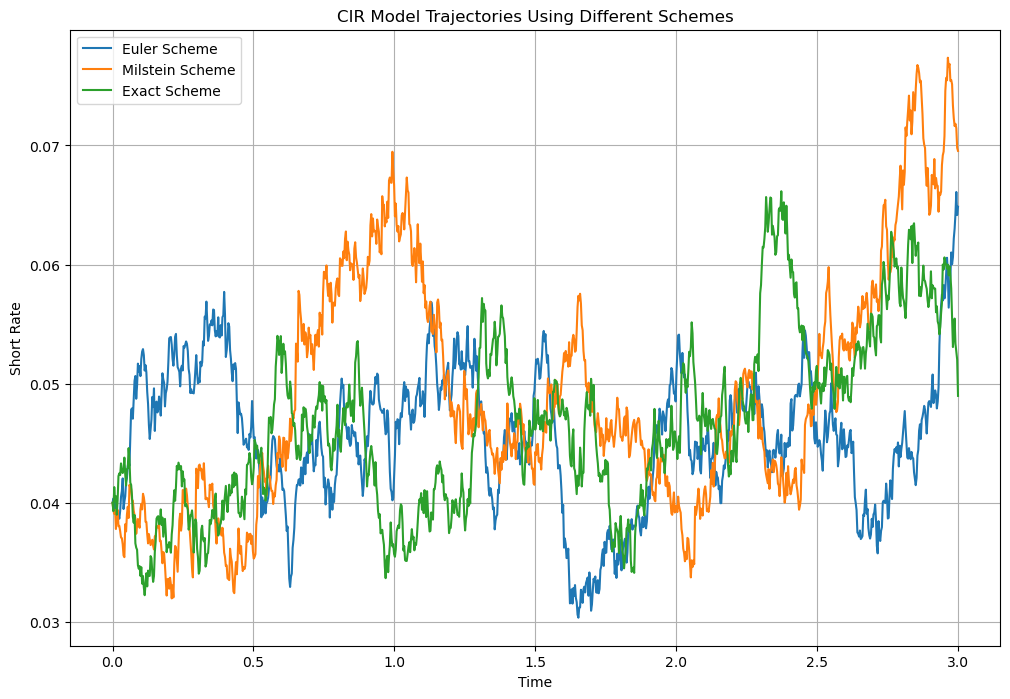

In [164]:
# 3e) 

def simulate_cir(T, M, r0, a, b, sigma, scheme):
    """
    Simulate CIR process using specified numerical scheme.
    
    Parameters:
        T (float): Terminal time.
        M (int): Number of time steps.
        r0 (float): Initial short rate.
        a (float): Speed of mean reversion.
        b (float): Long-term mean.
        sigma (float): Volatility parameter.
        scheme (str): Numerical scheme ("euler", "milstein", "exact").
    
    Returns:
        np.ndarray: Simulated short rate trajectory.
    """
    delta = T / M
    r = np.zeros(M + 1)
    r[0] = r0
    Z = np.random.normal(0, 1, M)  # Standard normal random variables

    for m in range(M):
        if scheme == "euler":
            r[m + 1] = r[m] + a * (b - r[m]) * delta + sigma * np.sqrt(max(r[m], 0)) * Z[m] * np.sqrt(delta)
        elif scheme == "milstein":
            sqrt_r = np.sqrt(max(r[m], 0))
            r[m + 1] = (r[m] + a * (b - r[m]) * delta + sigma * sqrt_r * Z[m] * np.sqrt(delta) +
                        (sigma**2 / (4 * max(r[m], 1e-8))) * (Z[m]**2 - 1) * delta)
        elif scheme == "exact":
            # Non-central chi-squared parameters
            k = 4 * a * b / sigma**2
            lambda_t = (4 * a * np.exp(-a * delta) * r[m]) / (sigma**2 * (1 - np.exp(-a * delta)))
            scale = (sigma**2 / (4 * a)) * (1 - np.exp(-a * delta))
            r[m + 1] = np.random.noncentral_chisquare(k, lambda_t) * scale
        else:
            raise ValueError("Invalid scheme. Choose 'euler', 'milstein', or 'exact'.")

    return r

# Parameters
T = 3
M = 1000
r0 = 0.04
a = 2
b = 0.05
sigma = 0.1

# Simulate using Euler, Milstein, and Exact schemes
schemes = ["euler", "milstein", "exact"]
results = {scheme: simulate_cir(T, M, r0, a, b, sigma, scheme) for scheme in schemes}

# Plot the results
plt.figure(figsize=(12, 8))
for scheme in schemes:
    plt.plot(np.linspace(0, T, M + 1), results[scheme], label=f"{scheme.capitalize()} Scheme")
plt.title("CIR Model Trajectories Using Different Schemes")
plt.xlabel("Time")
plt.ylabel("Short Rate")
plt.legend()
plt.grid()
plt.show()


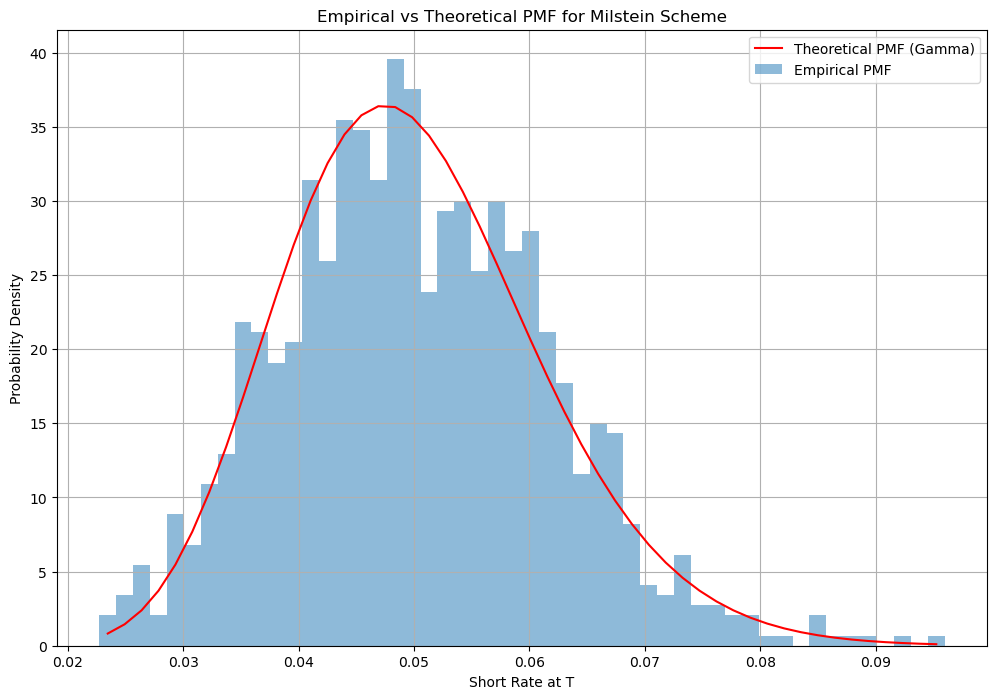

In [165]:
# 2f) 
def empirical_pmf(T, M, r0, a, b, sigma, scheme, N, num_bins):
    """
    Simulate N trajectories to construct empirical PMF at T.
    
    Parameters:
        T (float): Terminal time.
        M (int): Number of time steps.
        r0 (float): Initial short rate.
        a (float): Speed of mean reversion.
        b (float): Long-term mean.
        sigma (float): Volatility parameter.
        scheme (str): Numerical scheme ("euler", "milstein", "exact").
        N (int): Number of simulations.
        num_bins (int): Number of bins for the PMF.
    
    Returns:
        tuple: Bin centers, empirical probabilities, theoretical PMF.
    """
    r_T_values = np.zeros(N)
    for i in range(N):
        r_T_values[i] = simulate_cir(T, M, r0, a, b, sigma, scheme)[-1]
    
    # Bin the results
    bins = np.linspace(min(r_T_values), max(r_T_values), num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    empirical_counts, _ = np.histogram(r_T_values, bins=bins, density=True)
    
    # Theoretical stationary PMF (Gamma distribution)
    alpha_stationary = 2 * a * b / sigma**2
    beta_stationary = sigma**2 / (2 * a)
    theoretical_pmf = gamma.pdf(bin_centers, alpha_stationary, scale=beta_stationary)
    
    return bin_centers, empirical_counts, theoretical_pmf

# Parameters for PMF
N = 1000  # Number of simulations
num_bins = 50
bin_centers, empirical_counts, theoretical_pmf = empirical_pmf(T, M, r0, a, b, sigma, "milstein", N, num_bins)

# Plot empirical and theoretical PMF
plt.figure(figsize=(12, 8))
plt.bar(bin_centers, empirical_counts, width=bin_centers[1] - bin_centers[0], alpha=0.5, label="Empirical PMF")
plt.plot(bin_centers, theoretical_pmf, label="Theoretical PMF (Gamma)", color="red")
plt.title("Empirical vs Theoretical PMF for Milstein Scheme")
plt.xlabel("Short Rate at T")
plt.ylabel("Probability Density")
plt.legend()
plt.grid()
plt.show()


In [173]:
# 2g)

def total_squared_difference_matrix(T, M_list, N_list, r0, a, b, sigma, scheme, num_bins):
    """
    Compute total squared differences for varying M and N as a matrix.
    
    Parameters:
        T (float): Terminal time.
        M_list (list): List of time steps.
        N_list (list): List of number of simulations.
        r0 (float): Initial short rate.
        a (float): Speed of mean reversion.
        b (float): Long-term mean.
        sigma (float): Volatility parameter.
        scheme (str): Numerical scheme.
        num_bins (int): Number of bins.
    
    Returns:
        np.ndarray: Matrix of total squared differences with shape (len(M_list), len(N_list)).
    """
    matrix = np.zeros((len(M_list), len(N_list)))
    for i, M in enumerate(M_list):
        for j, N in enumerate(N_list):
            bin_centers, empirical_counts, theoretical_pmf = empirical_pmf(T, M, r0, a, b, sigma, scheme, N, num_bins)
            squared_diff = np.sum((empirical_counts - theoretical_pmf)**2 * (bin_centers[1] - bin_centers[0]))
            matrix[i, j] = squared_diff
    return matrix

# Parameters for squared differences
M_list = [10000]
N_list = [10000]
scheme = "milstein"  # Choose "euler", "milstein", or "exact"

# Compute the squared difference matrix
squared_diff_matrix = total_squared_difference_matrix(T, M_list, N_list, r0, a, b, sigma, scheme, num_bins)

# Display the results
import pandas as pd

# Create a DataFrame for easier visualization
df = pd.DataFrame(squared_diff_matrix, index=M_list, columns=N_list)
df.index.name = "M (Time Steps)"
df.columns.name = "N (Simulations)"

# Print the DataFrame
print(df)




KeyboardInterrupt: 

In [172]:
def total_squared_difference_matrix(T, M_list, N_list, r0, a, b, sigma, scheme, num_bins):
    """
    Compute total squared differences for varying M and N as a matrix.
    
    Parameters:
        T (float): Terminal time.
        M_list (list): List of time steps.
        N_list (list): List of number of simulations.
        r0 (float): Initial short rate.
        a (float): Speed of mean reversion.
        b (float): Long-term mean.
        sigma (float): Volatility parameter.
        scheme (str): Numerical scheme.
        num_bins (int): Number of bins.
    
    Returns:
        np.ndarray: Matrix of total squared differences with shape (len(M_list), len(N_list)).
    """
    matrix = np.zeros((len(M_list), len(N_list)))
    for i, M in enumerate(M_list):
        for j, N in enumerate(N_list):
            bin_centers, empirical_counts, theoretical_pmf = empirical_pmf(T, M, r0, a, b, sigma, scheme, N, num_bins)
            squared_diff = np.sum((empirical_counts - theoretical_pmf)**2 * (bin_centers[1] - bin_centers[0]))
            matrix[i, j] = squared_diff
    return matrix

# Parameters for squared differences
M_list = [10000]
N_list = [10000]
scheme = "milstein"  # Choose "euler", "milstein", or "exact"

# Compute the squared difference matrix
squared_diff_matrix = total_squared_difference_matrix(T, M_list, N_list, r0, a, b, sigma, scheme, num_bins)

# Display the results
import pandas as pd

# Create a DataFrame for easier visualization
df = pd.DataFrame(squared_diff_matrix, index=M_list, columns=N_list)
df.index.name = "M (Time Steps)"
df.columns.name = "N (Simulations)"

# Print the DataFrame
print(df)


N (Simulations)     10000
M (Time Steps)           
10000            0.056888
